# Building Makemore - Part 2: MLP

[Video](https://www.youtube.com/watch?v=TCH_1BHY58I)<br>
[Repository](https://github.com/karpathy/makemore)<br>
[Eureka Labs Discord](https://discord.com/invite/3zy8kqD9Cp)

## Table of Contents

- [Deep Dive: Bengio et al. 2003](#deep-dive-bengio-et-al-2003)
- [Building the Dataset](#building-the-dataset)
- [Character Embeddings](#character-embeddings)
- [Hidden Layer Construction](#hidden-layer-construction)
- [Output Layer](#output-layer)
- [Condensing the concepts](#condensing-the-concepts)
- [Working with the full dataset](#working-with-the-full-dataset)
    - [Accelerate with Batch-Processing](#accelerate-with-batch-processing)
    - [Improve the Learning Rate](#improve-the-learning-rate)
    - [Split the dataset](#split-the-dataset)
    - [Remove the Embedding Bottleneck](#remove-the-embedding-bottleneck)

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available

In the last session we built Makemore with a Bigram model and then we built it again with a super simple single-layer neural network.<br>
As already mentioned in the prior notebook, both of these approaches have serious limitations.<br>
For example, all predictions are always based on the *single* previous character, not on larger context sequences of characters.<br>

**And honestly: Neither of the two models really produce convincing names.**

If we could use more than one character to predict the next character, we would:

**a)** Have the two current approaches become really expensive really quickly<br>
**b)** *BUT:* Be able to make much better predictions from more available context

We had already noticed that the NN approach is noticably more flexible and scalable than Bigram.<br> 
We want to tweak it further. **We'll extend the single-layer NN to a deeper Multi-Layer Perceptron Model (MLP)**.<br>
In order to do so, we will follow the general approach from [this very well written paper. \[Bengio et al. 2003\]](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## Deep Dive: Bengio et al. 2003

With a vocabulary of $17,000$ words, the paper develops a *word-level* language model.<br>
This differs from our *character-level* approach.<br>
**We intend to keep our work character-level, but model our MLP just the same.**

The paper assigns a $30$-dimensional feature vector to each input word.<br>
A field $i$ in this vector does **not** correspond to the alphabetical index of the letter at position $i$ in the word. More on that later.<br>
In fact, the paper inputs each word itself. A lookup table for the letter indices is responsible for the conversion. The lookup table is $17,000\times 30$ in size. Each word (not character, but word) is an index in this table, which points to a unique $30$-dimensional vector.<br>

![](./images/bengioetal03.PNG)<br>
(This image is bottom-up, i.e. the input is at the bottom)

> In the NN, **multiple words** are read in as input, i.e. multiple word vectors.
> Example input: "A dog was running in a [...]"

Let's say we have three words embedded into three $30$-dimensional vectors.<br>
The resulting concatenation of these vectors forms the input for a fully-connected layer, activated by `tanh`, which can be chosen arbitrarily wide.<br>
(It is logically decoupled from the amount of words in the input in its own width)

Then follows another layer of the fixed width of $17,000$, where `softmax` is applied.<br>Softmax normalizes the outputs to partial probabilities over the set of possible words. In the end, the neuron with the highest assigned probability is chosen.<br>(And backprop is then performed, if training is running). This neuron represents an index for one of the $17,000$ trained words, the word to come next.

The dotted lines in the image can be ignored. That is an idea that we will not consider further here.<br>
So let's start (as with the prior makemore part) by creating the necessary data structures.

To summarize the above, we need:
- a lookup table for character embedding vectors
- a fully-connected layer, tanh activated, arbitrary width
- a fully-connected layer, softmax activated, width $17,000$
- a loss function
- a training loop

## Building the dataset

In [6]:
# read in all 32033 words
words = open('../names.txt', 'r').read().splitlines()
print(words[:8]) # show a sample of the first 8 names
print(len(words)) # this many words in total

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


Just like in the prior lecture, we create two maps 'integer-to-character' (`itos`) and 'character-to-integer' (`stoi`) to work with the $27$ possible characters.

In [7]:
# build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words)))) # set(): Throwing out letter duplicates

stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0 # Add this special symbol's entry explicitly

itos = {i:s for s,i in stoi.items()} # Switch order of (char, counter) to (counter, char)

# showing the two mappings, they really just are mirrors of one another
print(itos)
print()
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


To now build the dataset, we define a new paramter `block_size`, stating how many characters we will evaluate from the word in order to predict the next character. We set this to $3$ for now.

In [8]:
# Build the dataset
block_size = 3  # context length: how many characters used to predict the next? (1 before)
X, Y = [], []   # features (input to nn) and labels (output)

# Just showing off the first five words split into tokens
for w in words[:5]:
    print(f'\n{w}')
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # Showing what input and expected output now look like
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append, like a sliding window; NEAT!
        # old context starts at index 1 and is appended with the new index -> sliding window of block_size

# Again, these *do not* carry characters, but their respective indexes
X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .

olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .

ava
... ---> a
..a ---> v
.av ---> a
ava ---> .

isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .

sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [9]:
# This is what the dataset looks like right now
# 32 b.c If you count all the sliding windows across the first 
# five words (including the additional '.' character at the end 
# of each word), you'll get a total of 32.
print(f'Input:  {X.shape}\t{X.dtype}\t{X[0]}') # 32 times the 3 character indexes before the next one
print(f'Output: {Y.shape}\t{Y.dtype}\t{Y[0]}') # 32 times the next character's index

Input:  torch.Size([32, 3])	torch.int64	tensor([0, 0, 0])
Output: torch.Size([32])	torch.int64	5


## Character Embeddings

For this dataset, we now can pretty straight-forwardly setup the NN structure from the paper. We start with the lookup table `C`.<br>
We have $27$ possible characters ($26+1$).<br>
<br>
(The paper concerned $17,000$ words, which were compressed into $30$ dimensional representations)<br>
<br>
We will morph the $27$ characters into a numerical 2D space.<br>
We will use $2$ dimensions per character for now, so we can visualize the results later.<br>
This is not really compressing, but rather expanding the data. Still, works for our purposes.

In [10]:
# This will be the lookup table
# 27 rows, 2 chars
C = torch.randn((27, 2)) # each of 27 items has its own unique 2-dimensional numeric embedding in here
print(C)

tensor([[ 2.0009,  0.8303],
        [-0.9514, -1.4418],
        [-0.1610,  0.8722],
        [ 0.8944,  1.5010],
        [ 0.4226, -0.6039],
        [-0.2713, -1.3989],
        [-0.0760,  0.1450],
        [ 0.3027, -1.0453],
        [-0.7073,  0.0378],
        [ 0.3410, -0.7520],
        [-1.7593,  0.1331],
        [ 1.9800, -0.3726],
        [-0.8799, -0.7134],
        [-1.0207,  0.5494],
        [ 0.8065, -1.0045],
        [-2.3370,  1.7888],
        [ 1.6799,  0.0852],
        [ 0.4007, -0.4381],
        [-0.4803,  0.9483],
        [-0.0321,  1.1262],
        [ 1.2119, -0.8037],
        [ 0.0077,  0.1206],
        [-1.0894, -0.4437],
        [-1.0429, -1.5477],
        [ 0.2260, -0.3124],
        [ 0.8850, -0.3068],
        [ 0.0301, -1.3580]])


Before we embed all of $X$ into $C$, let's play around with this concept of embedding with a single numeric value first.

In [11]:
print(C[stoi['e']])

tensor([-0.2713, -1.3989])


Ok, that was pretty straight-forward.<br>
With our first iteration on Makemore, we used One-Hot Encoding.

Let's try that out here:

In [12]:
# Given 27 possible characters, embed the number 5 (e)
# one_hot encoding, encode integer 5, and tell it num_class is 27
# creates 26 dimension of all zeros, except 5th bit is turned on
# We get a one_hot vector, where 5th dimension is one, and shape is 27
F.one_hot(torch.tensor(5), num_classes=27) # shape is (27,)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

If we now multiply this One-Hot vector with the embedding matrix `C`, we get the same result as before: `C[5]`.<br>
**That is exactly what we want**.<br>

Even though this construct looks like a detour, we now have capped the value of possible inputs (i.e. the numerical letter indices) at a known, desired maximum of $27$.<br>
Remember, One-Hot Encoding allows for positional context and knowledge of range of value to make the whole thing much more robust.

To drive the point home, this is what we now do:

In [13]:
print(F.one_hot(torch.tensor(stoi['e']), num_classes=27).float() @ C) # stoi['e'] = 5
print(F.one_hot(torch.tensor(stoi['e']), num_classes=27).float() @ C == C[stoi['e']])

tensor([-0.2713, -1.3989])
tensor([True, True])


Going further now, we will *not* do this, simply because a direct call like `C[5]` is sufficient for our example.<br>
Still, the effect of One-Hot Encoding is very interesting in this case.<br>
<br>
**But how do we now get all $32\times 3$ integer values from $X$ embedded?**<br>
Where does the $32\times 3$ come from? Well, we have $32$ inputs from the originally $5$ words we comprised our dataset of. And each of these inputs consists of $3$ characters. The $32$ thus is directly related to our arbitrary choice of dataset size.<br>

Fortunately, Python is quite flexible when it comes to embedding.<br>
For example, you can request multiple datasets like this: `a[[3,4,5]]`, or `a[[torch.tensor([3,4,5])]]` or even `a[[torch.tensor([3,4,4,4,5])]]`.

We can use this to our advantage.

As `X` carries the indices of the characters, we can use it to index into `C` directly:

In [14]:
print(X[13, 2])   # Plugging out an example character, here 'a' from ..a ---> v (14th input, 3rd character)
# C = A lookup table for the letter indices is responsible for the conversion. The lookup table is  17,000×30
# in size. Each word (not character, but word) is an index in this table, which points to a unique 30
# -dimensional vector.
print(C[X][13,2]) # This construct actually returns the 2-dim. embedding vector for 'a'

# For all embeddings (character index to 2D vector) at once, Python can do this:
# embed all the integers in X
emb = C[X] # Done!

print(C[X].shape) # 32 times 3 times 2 -> 32 inputs, 3 characters each, 2 dimensional embedding vector each

tensor(1)
tensor([-0.9514, -1.4418])
torch.Size([32, 3, 2])


## Hidden Layer Construction

It's time to build the hidden layer. We can make it as wide as we want. But one thing is important:<br>
If we get three character vectors with two numerical values each, it makes for a total of $6$ inputs.<br>
(Below, a layer width of $100$ is chosen arbitrarily)

In [15]:
# weights initialized randomly
# 6 b/c there are 3 - 2dim embeddings print(emb.shape) -> torch.Size([32,3,2])
W1 = torch.randn((6, 100)) # 6 -> 3 vectors á 2 values, 100 neurons
b1 = torch.randn(100)      # for each of the 100 neurons, add a bias

# emb @ w1 + b1 won't work

# The multiplication of  𝑒𝑚𝑏( 32×3×2) with  𝑊1+𝑏1 (6×100) doesn't work.
# 32: Batch size (number of samples).
# 3: Sequence length (block_size or context length).
# 2: Embedding dimension (size of each character embedding).

What we essentially now want to do is $emb\ @\ W1 + b1$. But that doesn't work.<br>

**Problem:**<br>
The multiplication of $emb$ ($32\times 3\times 2$) with $W1 + b1$ ($6\times 100$) doesn't work.<br>
We'll have to find a way to reasonably attain a shape of ($32\times 6$) for the multiplication.<br>

**Solution:**<br>
We concatenate the $32$ individual $3\times 2$ vectors horizontally, instead of stacking them vertically on top of each other.<br>
Thus, we obtain $32$ vectors, one per input, with $6$ values each, two for each embedded character, in order of their appearance.<br>
There are many ways to achieve this. PyTorch is almost too versatile on this actually. Let's try the function `cat()`:

In [16]:
# 32 vectors, one for each input tuple, each 6-dimensional (3 characters, 2 values each)
emb[:, 0, :] # This is the first character's embedding vector for all 32 input tuples

print(emb[:, 0, :].shape) # 32 times 2 -> 32 inputs, 2 values each

torch.Size([32, 2])


In [17]:
# Concatenating all three input character embedding vectors into one 6-dimensional vector per input tuple
# 1 means: Concatenate along the first dimension (rows) -> 32 times 6
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1)
print(torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape)

torch.Size([32, 6])


This is exactly what we wanted.<br>
To repeat, for the $32$ inputs, i.e. the $32$ triplets, we now have $32$ vectors of width $6$ instead of $3$ vectors of width $2$.

**But, another problem:**<br>
If we were to change the block size from $3$ to something else, we would have to adapt this concatenation code.

**Solution:**<br>
Instead of `cat()`, we can use `unbind()` to split the tensor into a list of tensors, which we can then concatenate again with `cat()`.<br>
This way we can generalize the code to any block size, as the block size is now not hard-coded into the concatenation anymore.<br>
We build in a generalized way, what we had above with `emb[:,0,:]`, `emb[:,1,:]` and `emb[:,2,:]`.

In [18]:
# We separate the 32x3x2 into a tuple of 3 individual 32x2 tensors using unbind()
# 1 -> dimension 1 is the axis along a tuple of (therefore 3) tensors is created, each 32x2 (the other two dimensions)
print(torch.unbind(emb, 1)[0].shape) # This is equivalient to above list [emb[:,0,:], emb[:,1,:], emb[:,2,:]]
print(len(torch.unbind(emb, 1)))

torch.Size([32, 2])
3


In [19]:
# We concatenate the three 32x2 tensors into one big tensor, just like before
torch.cat(torch.unbind(emb, 1), 1) # concatenate all (3 here) individual 32x2 tensors along dimension 1 (a row is 3 2-dimensional vectors each -> 6-dimensional vector now)
print(torch.cat(torch.unbind(emb, 1), 1).shape) # 32 times 6

torch.Size([32, 6])


Before we continue: **What have we done here?**

We took the letters of our names. For each letter we recorded the $3$ preceding characters.<br>If there were none, this was filled and represented with the character `"."`, just like at the end of a word.<br>
The respective follow-up letter is the output we expect given the input of the $3$ preceding characters.<br>
The triplets are the inputs. But we embed them first, as we have seen above.

For each triplet, we go through the characters and assign the alphabetical character index.<br>
For each character index, we look up the corresponding $2$-dimensional embedding vector in lookup-table `C`.<br>
**Every letter in the triplet is now represented by a $2$-dimensional vector.**

The next layer has $6$ inputs and $100$ neurons. The $6$ result from the fact that we have a triplet as input, which is represented now by $3$ embedding vectors with $2$ elements each.<br><br>
And at this point, the above problem arises: We have $32$ triplets total and per triplet $3$ vectors with $2$ elements each, but we need $6$ elements to represent a triplet for the next layer.<br>
So we concatenate the $3$ vectors á $2$ values representing one triplet row-wise and in order into one vector of $6$ elements.<br>We do this for all $32$ triplets. Problem solved.

**But not quite**, because we had hard-coded the block size of $3$ into the code.<br>
This was generalized for any `block_size` through using `unbind()` with `cat()`.

Actually, let's take a closer look at how tensors are mendable in PyTorch:

In [20]:
a = torch.arange(18)
print(a.shape) # 18-dimensional vector

# Reshape to 3x3x2 tensor (works, as 3x3x2 = 18) (very efficient, no copying of data)
a = a.view(3, 3, 2)
print(a.shape)

# Can we transfer this approach to our 32x3x2 tensor problem?
True if torch.all(torch.eq(emb.view(32, 6), torch.cat(torch.unbind(emb, 1), 1))) else False
# Long story short: Yes, we can! All of the above is equivalent to just re-arranging how we look at the data

torch.Size([18])
torch.Size([3, 3, 2])


True

The `view()` function is very powerful.<br>
It allows us to reshape a tensor in any way we want, as long as the total number of elements stays the same.<br>
<br>
More on this [here \[ezyang’s blog\]](http://blog.ezyang.com/2019/05/pytorch-internals/).

Ok, now for real. We adjust the correct matrix `emb` with `view()`.<br>
We do this right away with the full definition for the calculation of the hidden layer:

In [21]:
# h is the result of the hidden layer
# h = emb.view(emb.shape[0],6) @ W1 + b1 # emb.shape[0] is 32, but this has to be variable (BUG!)

# Alternative to the above comment, again because of PyTorch:
# PyTorch reads the -1 and infers, because 6 is already used up from (2x3): 32 times 6 or inputs times 6 generally
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # produces 32 times 100 activations of the hidden layer

# Just for fun, let's see what h and its contents look like
print(h.shape)
print(h[0][:5])

torch.Size([32, 100])
tensor([ 0.4093, -1.0000, -0.9311, -0.4521,  0.9995])


With the above, we glossed over the intricacy that is multiplying and adding tensors correctly.<br>
It is the issue of broadcasting, again.

For the above, we know:

In [22]:
print((emb.view(-1,6) @ W1).shape)
print(b1.shape)

torch.Size([32, 100])
torch.Size([100])


With Broadcasting we first:
1) Align all dimensions to the right (of all tensors)

This is the case here:
- $[32, 100]$
- $[(1), 100]$ (the $1$ is added by broadcasting)

2) Now, expand the dimension of the tensor with the lower rank to match the dimension of the tensor with the higher rank

This is the case here:
- $[32, 100]$
- $[(32\times 1), 100]$ (we replicate the $100$ values of the $2^{\text{nd}}$ tensor $32$ times)

In effect, single one of the $32$ inputs is incremented by the same $100$ biases from the $2^{\text{nd}}$ tensor all the time.<br>
That's good, because we want to multiply each input with the same bias values.<br>
Remember, we don't train/alter these yet, so they are strictly the same every time.


## Output Layer

This will look somewhat familiar. It's closely related to the setup of the hidden layer.<br>
One thing is different though, apart from the different dimensions of the tensors: The activation function.<br>
We use softmax here instead of tanh to get a normalized probability distribution over the $17,000$ possible words.

In [23]:
# Choose softmax for probabilistic outputs and tanh for non-linear transformations in hidden layers.
# softmax returns [0,1]
# tanh returns [-1,1]
# Initialize weights and biases for the output layer randomly
W2 = torch.randn((100, 27)) # 100 inputs, 27 output neurons
b2 = torch.randn(27)        # 27 biases

# Neuron outputs
logits = h @ W2 + b2
print('Logits:', logits.shape) # This should be 32 times 27

# Softmax transforms outputs into probabilities
# exp() logits to get fake counts
counts = logits.exp()
# then normalize them into a probability
prob = counts / counts.sum(1, keepdims=True)
print('Probabilities:', prob.shape) # This should be 32 times 27 still

Logits: torch.Size([32, 27])
Probabilities: torch.Size([32, 27])


Now we have to compare the output of the probability distribution of the last layer to the respective label found in `Y`.<br>
To do this, first, we want to index into the rows of `prob` (the output of the last layer) with the indices found in `Y`.<br>
And we want to do this for each of the $32$ input triplets respectively.<br>

Let's quickly look at `Y` first:

In [25]:
Y[0] # This is the first expected output, the index of the first character in the first word

tensor(5)

This code now does what we set out above to do.<br>
It's beautiful:

In [26]:
# For each of the 32 input triplets, 
# give the probability for the correct output neuron, 
# which itself is accessed at the index stored in Y 
# at the same position
# we want these probability to be 1
print(prob[torch.arange(32), Y])
print(prob[torch.arange(32), Y].shape) # 32 probabilities, one for each input triplet

tensor([4.5470e-05, 3.1072e-09, 2.7529e-07, 4.3996e-11, 5.1231e-04, 8.8953e-09,
        2.2660e-06, 3.5607e-08, 2.3789e-16, 1.9398e-10, 3.8211e-08, 2.9198e-08,
        7.0668e-06, 4.3851e-05, 5.1244e-05, 4.5009e-09, 9.8500e-13, 9.8512e-08,
        1.4751e-03, 3.3123e-14, 6.3460e-06, 9.9995e-01, 2.0605e-03, 2.1800e-12,
        3.1279e-08, 3.5158e-11, 2.2981e-08, 3.4991e-02, 1.0328e-16, 5.0648e-15,
        1.3460e-04, 9.5219e-07])
torch.Size([32])


These are the probabilities assigned to the indices for which we know from `Y` that they should be $1.0$.<br>
With this knowledge, we now build the cost function to compare the predictions to the labels.

### Why Use Negative Log-Likelihood Loss?

#### Probabilistic Model Outputs:
- In classification tasks, the model's output is a probability distribution over classes (via **softmax** in the final layer).
- The goal is to **maximize the probability** of the correct class for each input.

#### Log-Probability:
- Probabilities are between **0** and **1**, so directly using them for optimization can lead to numerical instability (e.g., very small gradients for values close to **1**).
- **Taking the log of probabilities** ensures numerical stability and makes it easier to handle products of probabilities (as they turn into sums with logs).

#### Negative Log:
- The log of a probability is negative (since probabilities are in **(0, 1]**).
- To ensure the loss is positive (a standard convention in optimization), we take the **negative log**.

#### Minimization Goal:
- **Minimizing the negative log-probability** is equivalent to **maximizing the probability** of the correct class.

In [27]:
# create negative log-likelihood loss
# We want the average log proability over 
# all 32 inputs to be our loss

loss = -prob[torch.arange(32), Y].log().mean()
print(loss.item()) # This is to be minimized

17.178123474121094


## Condensing the concepts

The following is not really a recap, but a boiled down version of the above code:

In [28]:
print('X:', X.shape, ' Y:', Y.shape)

# Let's re-initialize the weights and biases
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)        # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)      # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)        # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)     # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)         # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # print the total number of parameters (nelements = number of elements) present in the tensors

X: torch.Size([32, 3])  Y: torch.Size([32])
3481 parameters


In [29]:
# Allowing for gradient accumulation
for p in parameters:
    p.requires_grad = True

In [30]:
# 1000 training steps (epochs)
for _ in range(1000):
    # Forward-Pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    # logits are output before activation function
    logits = h @ W2 + b2 # (32, 27)

    # logits = torch.tensor([-5, -3, 0, 5]) # safe when calling exp
    # logits = torch.tensor([-100, -3, 0, 100]) # not safe (returns inf or v. small number) exp can be overflowed
    # fixed with logits = torch.tensor([-100, -3, 0, 100]) + 5 in pyTorch - so use cross_entropy
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    
    # Replacing the above lines with PyTorch's built-in cross entropy
    # loss function: this function behaves better numerically and avoids pitfalls 
    # like infinities by subtracting the maximum value from all 
    # logits before exponentiating
    # low loss = good predictions
    loss = F.cross_entropy(logits, Y)

    # Backward-Pass
    for p in parameters:
        p.grad = None # Reset gradients (done before each backward pass to avoid accumulation over multiple passes)
    
    # populate gradients
    loss.backward()
    
    # Update
    # learning rate = -0.1
    for p in parameters:
        # nudge values by learning rate
        p.data += -0.1 * p.grad # Nudge parameter values in negative gradient direction (learning rate = 0.1)

print(loss.item())

0.2561309337615967


Cross-Entropy is often combined with a softmax function for classification tasks. Instead of separately applying the softmax and then calculating the log-likelihood, the F.cross_entropy function in PyTorch does both in one step. It also internally subtracts the maximum value from logits to avoid overflow when exponentiating large values.


We programmed this implementation of Cross-Entropy with Softmax pretty literally so far.<br>
This is pretty inefficient. PyTorch can provide significant performance boosts through internal condensing. 

This way:
1. The forward pass becomes more efficient
2. Backprop becomes more efficient
3. The Cross-Entropy is "numerically more well behaved", i.e. it is calculated more robustly (see the code comment on this)

With the above code, we train on only $32$ inputs. We overfit with our $3481$ network parameters, to be precise.

> The bigger the parameter count and the smaller the input set, the higher the risk of overfitting.

Comparing the logits (the actual network outputs) to the labels, we see that the predictions are mimicking the labels visibly:

In [109]:
print(logits.max(1)) # For each of the 32 inputs, give the index of the highest probability output neuron
print(f'\n{Y}')

torch.return_types.max(
values=tensor([9.4137], grad_fn=<MaxBackward0>),
indices=tensor([14]))

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])


In some cases, though, the predictions are not equal to the labels. Why is that?<br>
In pracice, we will actually never reach a $0.00$ Loss. This is because of triplets and labels like these:

`... -> a`<br>
`... -> e`

**Given the same input, different outputs are expected.**

## Working with the full dataset

Rewind. We start with the full dataset again. Forget the ominous $32$ inputs.<br>
Now its this many:

In [27]:
# Build the dataset
block_size = 3  # context length: how many characters used to predict the next? (1 before)
X, Y = [], []   # features (input) and labels (output)

# Just show the first three words as example
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        
        X.append(context)
        Y.append(ix)
        
        # Showing what input and expected output now look like
        context = context[1:] + [ix] # crop and append, like a rolling window; NEAT!

# These DO NOT carry characters, but their respective index numbers
X = torch.tensor(X)
Y = torch.tensor(Y)

print('Input:', X.shape, X.dtype, X[0])
print('Output:', Y.shape, Y.dtype, Y[0]) 

Input: torch.Size([228146, 3]) torch.int64 tensor([0, 0, 0])
Output: torch.Size([228146]) torch.int64 tensor(5)


In [28]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters') # Network stays the same, so same number of parameters

3481 parameters


In [29]:
# Allowing for gradient accumulation
for p in parameters:
    p.requires_grad = True

In [30]:
for _ in range(10):
    # Forward-Pass
    emb = C[X] # (228146, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
    logits = h @ W2 + b2 # (228146, 27)

    # Leaving this here for happy memories of low performance:
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    
    loss = F.cross_entropy(logits, Y)
    
    print(loss.item())
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # Update
    for p in parameters:
        p.data += -0.1 * p.grad

19.505226135253906
17.084487915039062
15.776531219482422
14.833340644836426
14.002603530883789
13.253260612487793
12.57991886138916
11.983101844787598
11.47049331665039
11.05185604095459


### Accelerate with Batch-Processing

It takes quite a while to do a Forward-Pass and Backward-Pass over so many parameters at once.<br>
**The training process can be accelerated through Batch-Processing**.<br>
We want to randomly draw some $n$ inputs from the dataset and train on this subset. Forward. Backward. Update. All done exclusively on this subset.<br>
Then we draw another $n$ inputs and repeat the process.<br>
We do this until we have gone through the whole dataset once. This is called an **epoch**.<br>

In [76]:
print(torch.randint(0, X.shape[0], (32,))) # Construct a tensor of 32 randomly drawn numbers between 0 and 228146

tensor([18, 14,  5, 24, 29, 27, 20, 24,  6,  0, 27,  4, 11, 27,  1,  3, 10,  4,
        20, 12, 25, 10, 10, 12, 23,  3, 26, 14,  5,  5,  9, 14])


In [77]:
# Reset the parameters once again for this new approach
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters') # Network stays the same, so same number of parameters

for p in parameters:
    p.requires_grad = True

3481 parameters


In [78]:
for _ in range(1000):
    
    # mini-batch construction -> 32 indices of 3-dimensional character index vectors within X
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward-Pass
    emb = C[X[ix]] # (32, 3, 2), a single batch, X[ix] grabs only the 32 indices, C then grabs the 2-dimensional vectors for each of the 3 characters for the current of the 32 triplets
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix]) # Y[ix] grabs the 32 expected output indices for the current batch (very elegant)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # Update
    for p in parameters:
        p.data += -0.1 * p.grad

print('Loss for current mini-batch:', loss.item())

Loss for current mini-batch: 0.29219260811805725


In [79]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print('Loss for entire dataset:', loss.item())

Loss for entire dataset: 0.26934054493904114


This is much faster, but less accurate. Still, this is the more efficient way, because through the subset of batches we are optimizing with a more quickly derived, yet just slightly deviating gradient each time.<br>
**We are thus staggering towards the optimum, but the direction is still roughly correct.**

### Improve the Learning Rate

The learning rate is a hyperparameter that controls how much the model’s weights (or parameters) are adjusted during training. It determines the step size taken in the direction of the negative gradient of the loss function, which helps the model learn over time.

- Large learning rate: If the learning rate is too large, the model might overshoot the optimal solution, causing the loss to diverge instead of converging.
- Small learning rate: If the learning rate is too small, the model will learn very slowly, and it might get stuck in local minima or plateau before reaching the global minimum.

The batch approach reveals new questions.<br>
If you're now just staggering around, what is a good learning rate?<br>
So far it was $0.1$, but now?

The following steps are recommended to find a good learning rate for the batch approach:
1. Reset parameters
2. Choose a small number of iterations, e.g. $100$ (for batch-processing)
3. Through trial and error and resetting and running with new learning rates: Optimum lies somewhere between $1$ and $0.001$. (Otherwise the gradient is too strong)
4. We build a set of possible learning rates with `torch.linspace`

In [90]:
# 1000 values between -3 and 0, linearly spaced
# lre = learning rate exponent
# builds set of possible learning rates
lre = torch.linspace(-3, 0, 1000) 
lrs = 10 ** lre # 1000 values between 10^-3 and 10^0
# lrs

With the above defined learning rate candidates, we now, per candidate, draw a batch of inputs and train on the batch.<br>
Then we plot the loss for each learning rate candidate. The learning rate with the lowest loss is deemed the best.<br>
This makes setting the learning rate a much more educated guess. (Still somewhat a guess, though)

In [81]:
# Reset the parameters once again
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

for p in parameters:
    p.requires_grad = True

lri = []   # List of applied learning rates
lossi = [] # List of resulting losses for each learning rate respectively

for i in range(1000):
    # mini-batch construction
    ix = torch.randint(0, X.shape[0], (32,)) # (32,)
    
    # Forward-Pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    # The loss is calculated using F.cross_entropy, which 
    # combines the softmax activation
    # and negative log-likelihood loss in one step.
    loss = F.cross_entropy(logits, Y[ix])
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Set learning rate candidate
    lr = lrs[i]
    
    for p in parameters:
        p.data += -lr * p.grad
    
    # Tracking stats
    lri.append(lre[i])
    # lri.append(lr)
    lossi.append(loss.item())
    
print('Loss for current mini-batch:', loss.item())

Loss for current mini-batch: 0.630765974521637


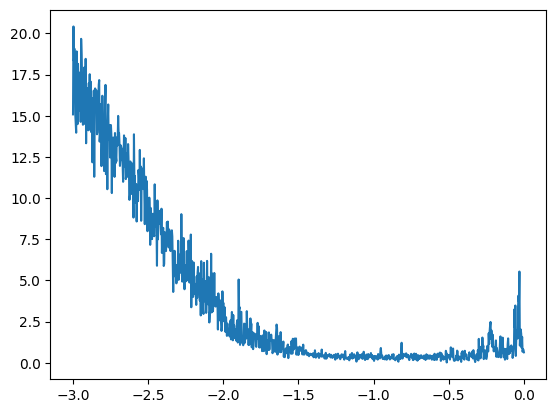

In [82]:
plt.plot(lri, lossi);

Let's go further and actually determine the $lri$ associated with the lowest loss:

In [83]:
# Get index of smallest loss in lossi
print(lri[lossi.index(min(lossi))])

tensor(-0.5135)


With this, we have a well-founded confirmation that $0.1$ is within a good region of values to choose for the learning rate.<br>
Smaller values have the descent bottom out at a too shallow level, while larger values make the descent too bumpy.<br> 
Note that now, also, towards the end of the training, learning rate decay is applied.

Ok, then let's train properly now:

In [87]:
# Reset the parameters once again
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

for p in parameters:
    p.requires_grad = True

In [88]:
for i in range(70000):
    
    # mini-batch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward-Pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate decay to more closely approach the minimum
    lr = 0.1 if i < 50000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad
    
print('Loss for current mini-batch:', loss.item())

Loss for current mini-batch: 0.207481250166893


In [89]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print(loss.item())

0.25267383456230164


We achieved a lower loss than before. But is that good? How do we know?<br>
The model itself is small, only $3481$ parameters. Larger models could bring better performance, or bad cases of overfitting.<br><br>How could we detect that?

### Split the dataset

The larger the model, the bigger the risk of it memorizing the dataset verbatim. This is called, and we've seen this before, **overfitting**.<br>
So, to avoid our performance measurements to be distorted by how well the model may have just memorized instead of generalized,<br>we need to split the dataset into portions for training, validation and testing.<br>The latter ones the model has never trained on, so we can use them to measure the generalization performance of the model.

There is `training split`, `dev/validation split`, `test split`.<br> The distribution of the data among these subsets is roughly chosen domain-independently like this: $80\%$, $10\%$, $10\%$

Splitting the datset looks like this:

In [55]:
import random

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, '\tY:', Y.shape)
    return X,Y

random.seed(42)          # for reproducibility
random.shuffle(words)    # words is just the bare list of all names, from wayyy above
n1 = int(0.8*len(words)) # index at 80% of all words (rounded for integer indexing)
n2 = int(0.9*len(words)) # index at 90% of all words (rounded for integer indexing)

print('Training Set:')
Xtr, Ytr = build_dataset(words[:n1])     # The first 80% of all words
print('Validation Set:')
Xdev, Ydev = build_dataset(words[n1:n2]) # The 10% from 80% to 90% of all words
print('Test Set:')
Xte, Yte = build_dataset(words[n2:])     # The 10% from 90% to 100% of all words

Training Set:
X: torch.Size([182625, 3]) 	Y: torch.Size([182625])
Validation Set:
X: torch.Size([22655, 3]) 	Y: torch.Size([22655])
Test Set:
X: torch.Size([22866, 3]) 	Y: torch.Size([22866])


Before we play around with the model architecture, let's first see how well the current model performs on the validation set and the test set when trained on the training set only:

In [43]:
# Reset the parameters once again
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

3481 parameters


In [44]:
# update to use training data Xtr, Ytr
for i in range(40000):
    
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate decay to more closely approach the minimum
    lr = 0.1 if i < 30000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad
    
# print('Loss for current mini-batch:', loss.item())

In [45]:
# Validation loss
# using Dev data
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.34187912940979


In [46]:
# Test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.338966131210327


We can see that validation and test loss are about equal. This is good. It means that the model is not overfitting.<br>
The model is not powerful enough to memorize the training set, as it's too small.<br><br>**We underfit.**<br><br>
This is a sign for us that we are in fact able to increase the model size without risking overfitting too quickly.<br>

If we want to really see the impact of splitting the dataset, we need to start playing around with the total parameter count of the model.<br>
We can do this by changing the width of the hidden layer. 

Let's try $300$ instead of $100$ neurons:

In [47]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn((300), generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

10281 parameters


In [96]:
lossi = [] # list of losses per mini-batch
stepi = [] # list of steps (mini-batches)

for i in range(180000):
    
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) 
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if i < 60000 else 0.05 if i < 120000 else 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
    
    # Loss per mini-batch tracking
    stepi.append(i)
    lossi.append(loss.item())
    
#print('Loss for current mini-batch:', loss.item())

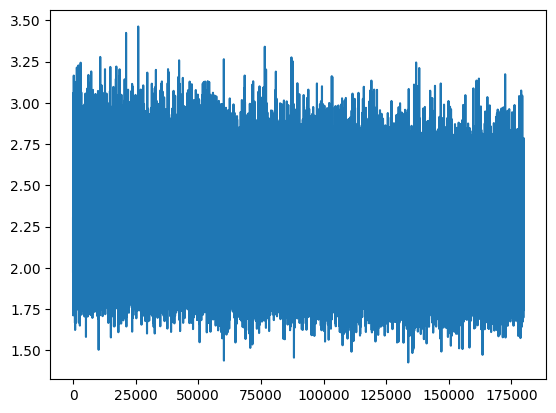

In [97]:
plt.plot(stepi, lossi);

The plot's thickness is due to mini-batch gradient descent. More precisely, different mini-batches have a bit deviating, different loss values.<br>
This is because the mini-batches are randomly drawn from the training set.<br>
In total, though, they visibly converge and follow the same trend.

> In general, the larger the batch size, the more stable the training process. But also the more memory is required.

In [98]:
# Training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.228414535522461


In [99]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.2374050617218018


In [100]:
# Test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.240673303604126


The losses for the training set, the validation set and the test set are in the same vicinity.<br>
This is good. It means that the model is not overfitting.<br>

Let's now visualize the embeddings that were trained by the model (the weights and biases of the embedding layer).<br>
We visualize `C`, because that is where we put the trainable, two-dimensional embedding vectors.<br>
Let's see if the training affected these embeddings in a meaningful way:

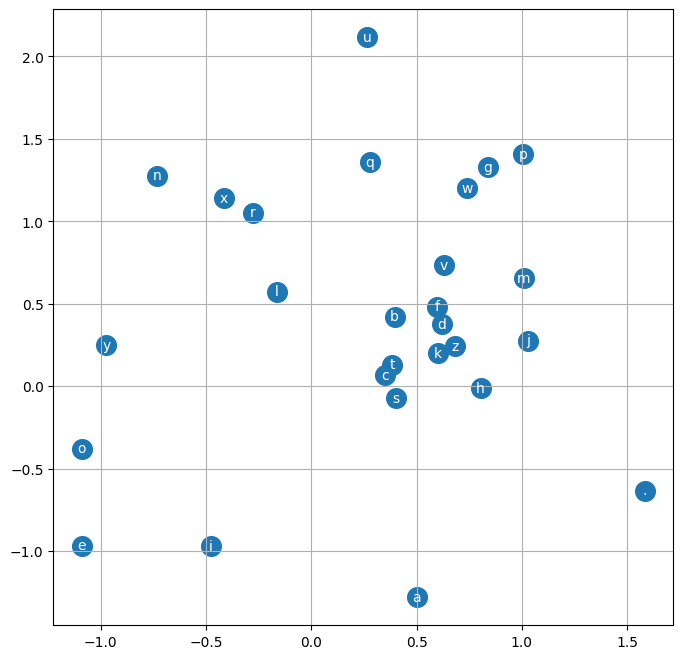

In [101]:
# This code plots the 2-dimensional embeddings of the 27 characters
plt.figure(figsize=(8,8))
# plt.scatter(x,y,s)
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

We can see the vowels are clustered together. This means that the model has learned that vowels are, to some extend, interchangeable and therefore somewhat alike in character.<br>
`q` seems to be very unique, just like our special `.` character. We can see structure, it's not just pure randomness.<br>


Let's optimize further beyond increasing the model's hidden layer.<br>
Let'stackle the next possible bottleneck: **The dimensions of the character embeddings.**

## Remove the Embedding Bottleneck

For a first run, let's increase the embedding dimensions to $10$.<br>
With the below code, the goal was to beat Andrej's validation loss of $2.17$:

In [103]:
import tqdm
import random

In [104]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, '\tY:', Y.shape)
    return X,Y

random.seed(42)          # for reproducibility
random.shuffle(words)    # words is just the bare list of all names, from wayyy above
n1 = int(0.8*len(words)) # index at 80% of all words (rounded for integer indexing)
n2 = int(0.9*len(words)) # index at 90% of all words (rounded for integer indexing)

print('Training Set:')
Xtr, Ytr = build_dataset(words[:n1])     # The first 80% of all words
print('Validation Set:')
Xdev, Ydev = build_dataset(words[n1:n2]) # The 10% from 80% to 90% of all words
print('Test Set:')
Xte, Yte = build_dataset(words[n2:])     # The 10% from 90% to 100% of all words

Training Set:
X: torch.Size([182580, 3]) 	Y: torch.Size([182580])
Validation Set:
X: torch.Size([22767, 3]) 	Y: torch.Size([22767])
Test Set:
X: torch.Size([22799, 3]) 	Y: torch.Size([22799])


In [105]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# 10 dimensial embeddings for each word
C = torch.randn((27, 10), generator=g) # C=feature vectors
# 30 (10X3) inputs to hidden layer
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True
    
lossi = []
stepi = []

11897 parameters


In [106]:
for i in tqdm.tqdm(range(300000)):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (128,)) # Batch size was 32 before, now 128
    
    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h1 = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 300)
    logits = h1 @ W2 + b2 # (32, 50)
    loss = F.cross_entropy(logits, Ytr[ix]) # (32,)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 60000 else 0.05 if i < 120000 else 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())
    
# print('Loss for current mini-batch:', loss.item())

100%|███████████████████████████████████████████████████████████| 300000/300000 [01:39<00:00, 3021.99it/s]


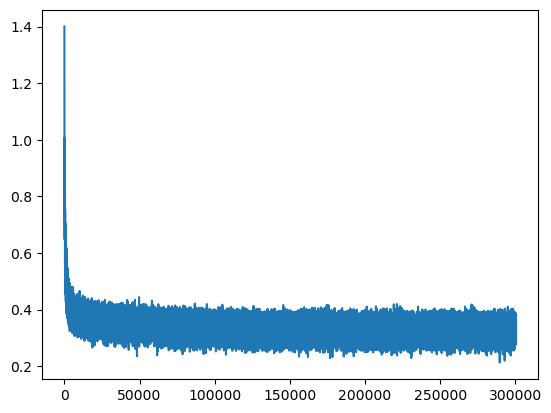

In [58]:
plt.plot(stepi, lossi);

In [59]:
# Validation loss w/ dev
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1522507667541504


In [60]:
# Training loss w test
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.12158203125


Training and validation performance are slightly, very slowly, drifting apart. **This is a sign of overfitting.**<br>
We could now go and increase the model input from three to four characters per tuple.

In [108]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

# generate 20 samples
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # embed current context
        # first dimension is size of training set
        emb = C[torch.tensor([context])] # (1, block_size, d)
        # embedding get projected into end state
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        # softmax exponentiats logits and makes them sum to 1
        # similar to cross entropy in that it prevents overflows
        probs = F.softmax(logits, dim=1)
        # sample from probabilities to get next index
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context window to append the index
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

carlaizabelle.
khi.
mili.
taty.
sacaysie.
mahuel.
den.
rha.
kaeli.
ner.
kia.
chaiir.
kaleigh.
ham.
jory.
quint.
sulin.
alianni.
watero.
dearyxi.


<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>